## Exercícios

Neste exercício, você usará a classe `KMeans` que construímos para explorar um novo dataset e descobrir seus agrupamentos naturais.

O dataset escolhido é o **"Wine dataset"**, que contém a análise química de vinhos cultivados na mesma região da Itália, mas derivados de três cultivares (tipos de uva) diferentes. O objetivo é ver se o K-Means consegue agrupar os vinhos de acordo com seu cultivar, usando apenas as suas características químicas.

### Tarefa 1: Análise e Seleção de Features

Primeiro, carregue o dataset `wine` e use a função `seaborn.pairplot` para visualizar as relações entre as features. Analise o gráfico e escolha o par de features que você acredita que melhor separa os 3 grupos. Plote um gráfico de dispersão apenas com o par selecionado.

In [1]:
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
import numpy as np

wine = load_wine()
X = wine.data
y = wine.target

# Para facilitar o uso com o Seaborn, vamos criar um DataFrame do Pandas
wine_df = pd.DataFrame(X, columns=wine.feature_names)
wine_df


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


c:\Users\gteix\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\gteix\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\gteix\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\gteix\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\gteix\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been as

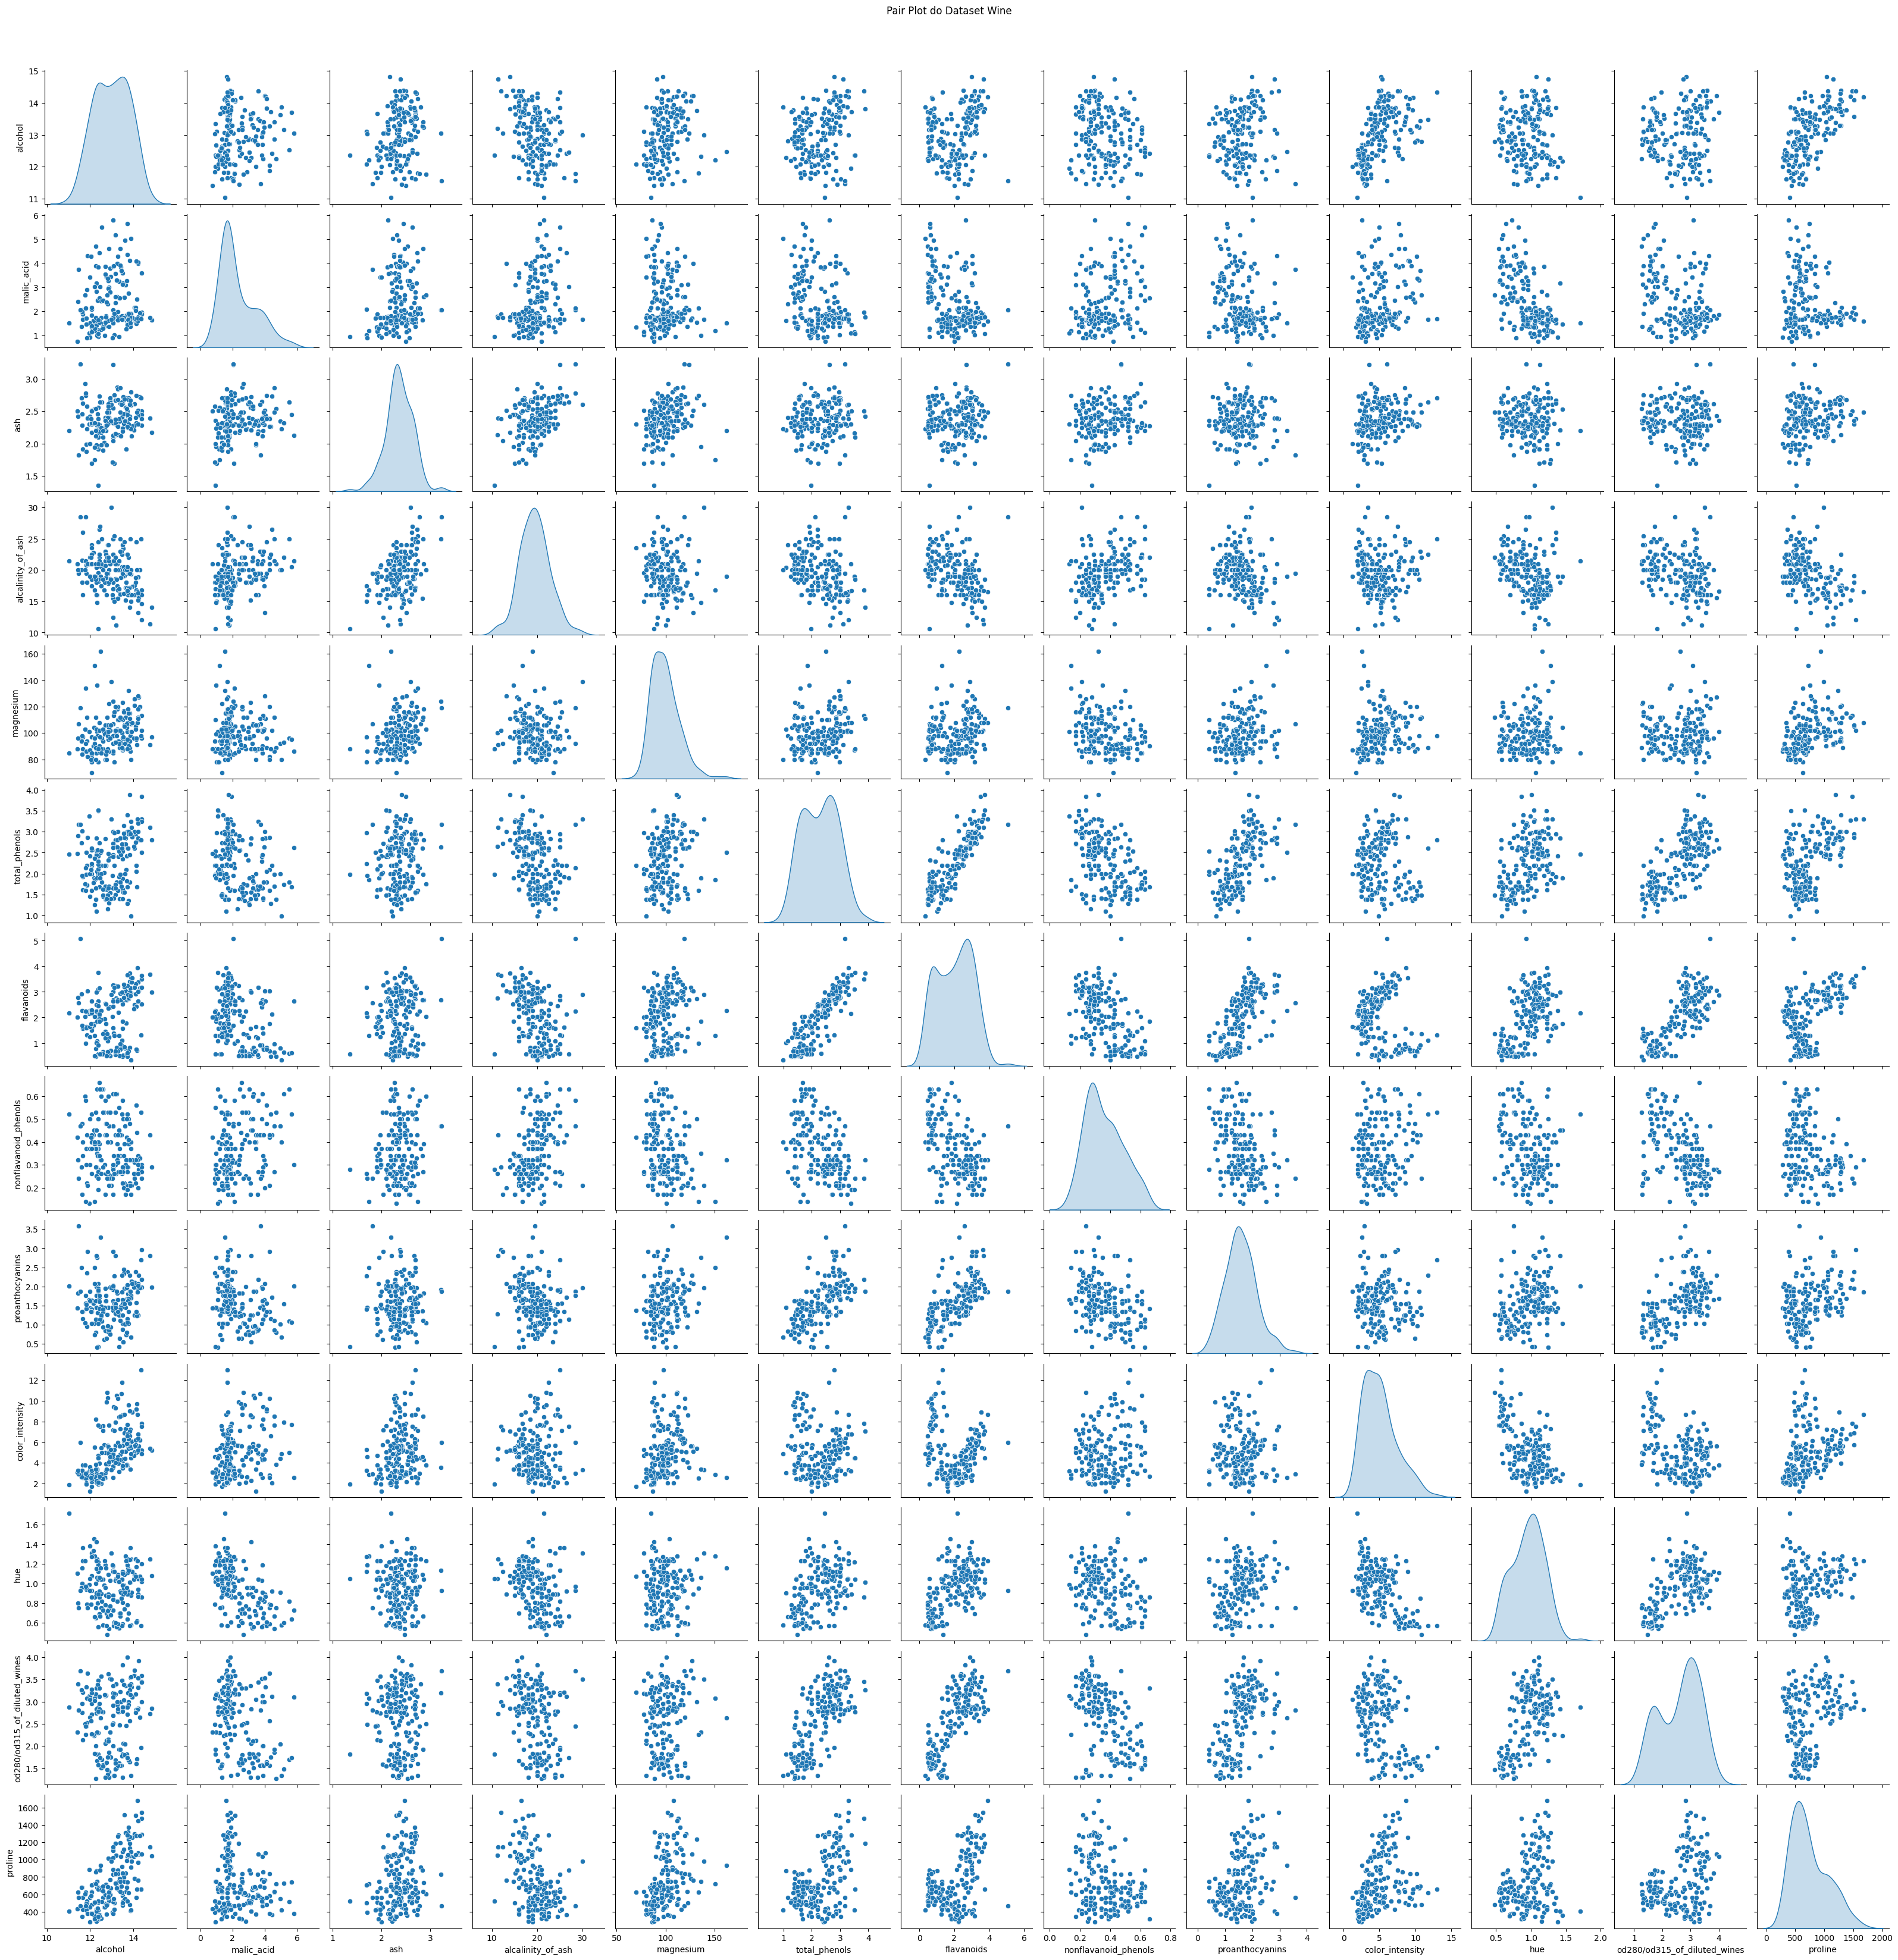

In [2]:
sns.pairplot(wine_df, hue=None, palette='viridis', diag_kind='kde')
plt.suptitle('Pair Plot do Dataset Wine', y=1.02) # Ajusta o título para não sobrepor
plt.show()

Escolhi as features flavanoids e color_intensity pois aparentemente elas são as que estão mais visualmente definidas e densas.

C:\Users\gteix\AppData\Local\Temp\ipykernel_21380\1573241186.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=wine_df, x=feature_x, y=feature_y, hue=None, palette='viridis')


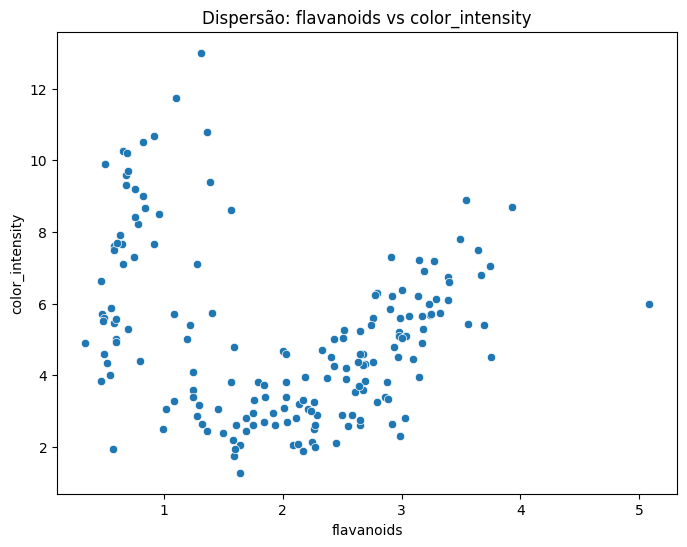

In [4]:
# Escolher as duas features
feature_x = 'flavanoids'
feature_y = 'color_intensity'

# Plotar gráfico de dispersão
plt.figure(figsize=(8,6))
sns.scatterplot(data=wine_df, x=feature_x, y=feature_y, hue=None, palette='viridis')
plt.title(f'Dispersão: {feature_x} vs {feature_y}')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.show()

In [17]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """
        Inicializa os centróides selecionando K pontos aleatórios do dataset.
        """
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        random_indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_indices]

    def _assign_clusters(self, X):
        """
        Atribui cada ponto de dado ao centróide mais próximo.
        """
        n_samples = X.shape[0]
        distances = np.zeros((n_samples, self.n_clusters))

        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)
        
        self.labels = np.argmin(distances, axis=1)

    def _update_centroids(self, X):
        """
        Atualiza a posição de cada centróide com base na média dos pontos atribuídos a ele.
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        
        for i in range(self.n_clusters):
            cluster_points = X[self.labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = np.mean(cluster_points, axis=0)
            else:
                new_centroids[i] = self.centroids[i]
        
        self.centroids = new_centroids

    def fit(self, X):
        """
        Executa o algoritmo K-Means.
        """
        self._initialize_centroids(X)

        for _ in range(self.max_iter):
            old_centroids = self.centroids.copy()
            self._assign_clusters(X)
            self._update_centroids(X)
            if np.allclose(old_centroids, self.centroids):
                break

    def predict(self, X):
        """
        Atribui clusters para novos dados com base nos centróides aprendidos.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i, centroid in enumerate(self.centroids):
            distances[:, i] = np.sum((X - centroid)**2, axis=1)
        
        return np.argmin(distances, axis=1)

### Tarefa 2: Encontrando o K Ótimo

Aplique o Método do Cotovelo nas duas features que você escolheu. Calcule e plote a inércia (WCSS) para K de 1 a 10. Com base no seu gráfico, qual parece ser o número ideal de clusters?

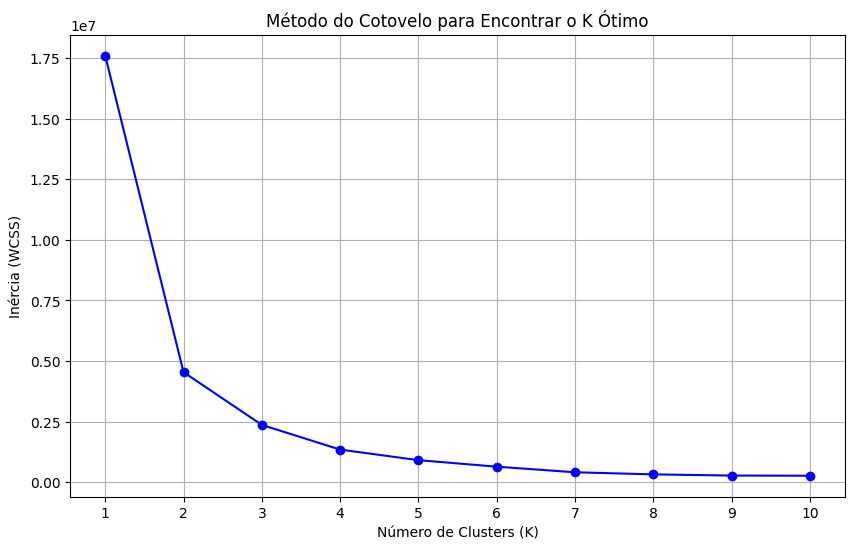

O número ideal de Clusters aparenta ser 3 pois é a partir dele que aumentar os cluster não altera tanto a Inércia


In [18]:
# Implementando o Método do Cotovelo com visualização iterativa
k_range = range(1, 11)
inertias = []
clustering_results = []

for k in k_range:
    model = KMeans(n_clusters=k, max_iter=150, random_state=42)
    model.fit(X)
    
    # Calcular a inércia (WCSS)
    current_inertia = 0
    for i in range(k):
        # Seleciona os pontos pertencentes ao cluster i
        cluster_points = X[model.labels == i]
        # Calcula a soma das distâncias quadradas ao centróide do cluster i
        current_inertia += np.sum((cluster_points - model.centroids[i])**2)
    
    inertias.append(current_inertia)
    clustering_results.append({'labels': model.labels, 'centroids': model.centroids})

# Plotar o gráfico do cotovelo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia (WCSS)')
plt.title('Método do Cotovelo para Encontrar o K Ótimo')
plt.xticks(k_range)
plt.grid(True)
plt.show()
print('O número ideal de Clusters aparenta ser 3 pois é a partir dele que aumentar os cluster não altera tanto a Inércia')

### Tarefa 3: Clusterização e Avaliação

Use o K encontrado na tarefa anterior para treinar seu modelo `KMeans`. Crie um gráfico com dois subplots: um mostrando os clusters encontrados pelo algoritmo e outro mostrando os dados com os rótulos reais para comparação. Por fim, calcule a taxa de acertos e comente o resultado.

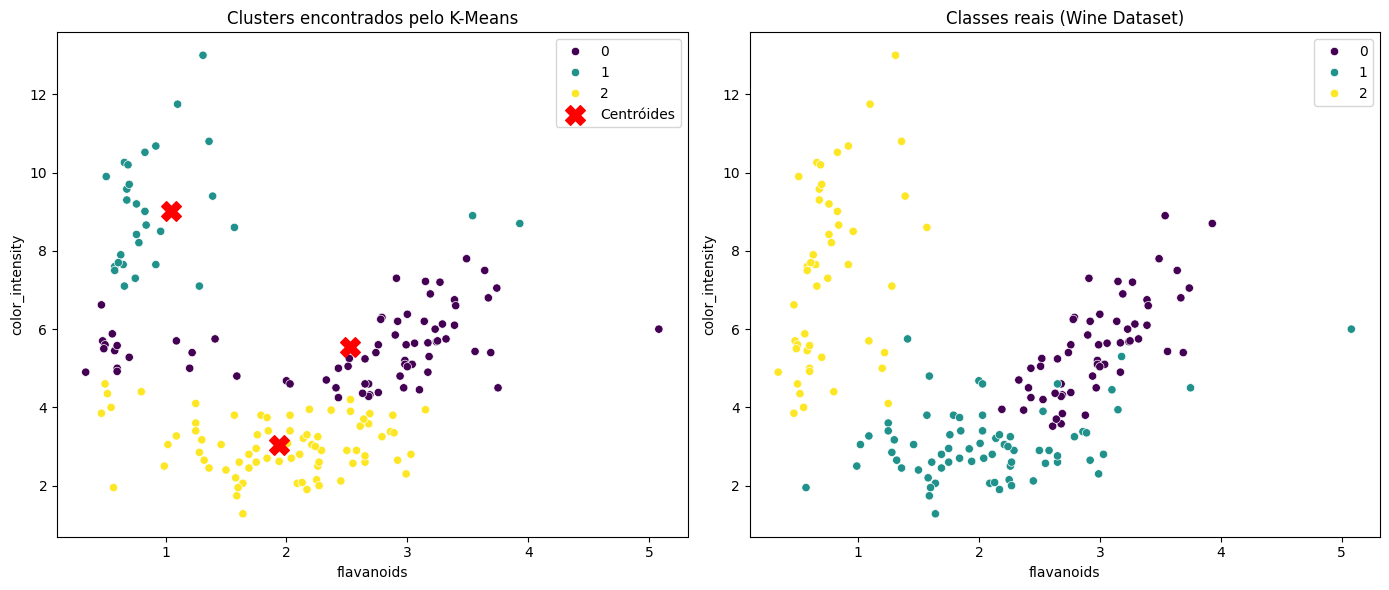

Taxa de acertos: 78.09%


In [ ]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score


X_sel = pd.DataFrame(X, columns=wine.feature_names)[[feature_x, feature_y]].values

# Treinar seu modelo KMeans (usando seu código personalizado)
kmeans = KMeans(n_clusters=3, max_iter=150, random_state=42)
kmeans.fit(X_sel)

# Obter os rótulos dos clusters e centróides
pred_labels = kmeans.labels
centroids = kmeans.centroids

fig, axs = plt.subplots(1, 2, figsize=(14,6))

# Clusters encontrados
sns.scatterplot(x=X_sel[:, 0], y=X_sel[:, 1], hue=pred_labels, palette='viridis', ax=axs[0])
axs[0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Centróides')
axs[0].set_title('Clusters encontrados pelo K-Means')
axs[0].set_xlabel(feature_x)
axs[0].set_ylabel(feature_y)
axs[0].legend()

# Classes reais
sns.scatterplot(x=X_sel[:, 0], y=X_sel[:, 1], hue=y, palette='viridis', ax=axs[1])
axs[1].set_title('Classes reais (Wine Dataset)')
axs[1].set_xlabel(feature_x)
axs[1].set_ylabel(feature_y)

plt.tight_layout()
plt.show()

#Acertos
labels_map = np.zeros_like(pred_labels)
for i in range(3):
    mask = (pred_labels == i)
    if np.any(mask):
        labels_map[mask] = mode(y[mask], keepdims=True).mode[0]

accuracy = accuracy_score(y, labels_map)
print(f"Taxa de acertos: {accuracy * 100:.2f}%")